In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import os
# import json


In [40]:
file_path = r'D:\\Documents\\Mémoire\\Data John Doe\\John Doe gaitway 3D locomotion_R16.txt'
output_file = r'D:\\Documents\\Mémoire\\Data John Doe\\Auto Python\\RAWSpeed\\ResultPython_JD_R16.txt'

seuil_p=4.55
seuil_v=4.35

MAX_TIME_DIFF = 0.38
MIN_TIME_DIFF = 0.28


In [41]:
# Lire le fichier en ignorant les 43 premières lignes
data = pd.read_csv(file_path, delimiter='\t', header=None, skiprows=44)

# Extraire les colonnes nécessaires
time = data[0]
raw_speed = (1164.1/data[9])
contact_mode = data[31]

# Initialiser les listes pour stocker les vallées, les peaks et les transitions de contact mode
valleys = []
peaks = []

# Previous value, should be "PIC", or "VAL"
was_previous = None
previous_type = None


In [42]:
# Supprimer les spike selon 2 conditions (>4xEcartType AND EcartType>0.5) sur les 5 valeurs d'avant. Remplace par la moyenne des 5
def remove_spikes(raw_speed):
    # Créer une copie du signal
    filtered_speed = raw_speed.copy()
    
    # Parcourir chaque point du signal à partir du 6e point
    for i in range(5, len(raw_speed)):
        # Calculer la moyenne et l'écart-type des 5 valeurs précédentes
        previous_values = raw_speed[i-5:i]
        mean_previous = np.mean(previous_values)
        std_previous = np.std(previous_values)
        
        # Vérifier si la différence est un pic
        if abs(raw_speed[i] - mean_previous) > 4 * std_previous and abs(raw_speed[i] - mean_previous) > 0.5:
            # Remplacer par la moyenne des 5 valeurs précédentes
            filtered_speed[i] = mean_previous
    
    return filtered_speed

filtered_speed = remove_spikes(raw_speed)


In [43]:
# # Vous pouvez les installer avec : pip install ipywidgets
# import ipywidgets as widgets
# from IPython.display import display
# 
# # Fonction pour mettre à jour l'affichage lorsque la valeur du curseur change
# def on_value_change(change):
#     print(f'La valeur actuelle du curseur est: {change["new"]}')
# 
# # Créer un curseur
# slider = widgets.FloatSlider(
#     value=5.0,       # Valeur initiale
#     min=0.0,         # Valeur minimale
#     max=10.0,        # Valeur maximale
#     step=0.1,        # Pas entre les valeurs
#     description='Slider:',
#     continuous_update=False  # Met à jour uniquement lorsque vous relâchez le curseur
# )
# 
# # Afficher le curseur
# display(slider)
# 
# # Associer la fonction à l'événement de changement de valeur du curseur
# slider.observe(on_value_change, names='value')

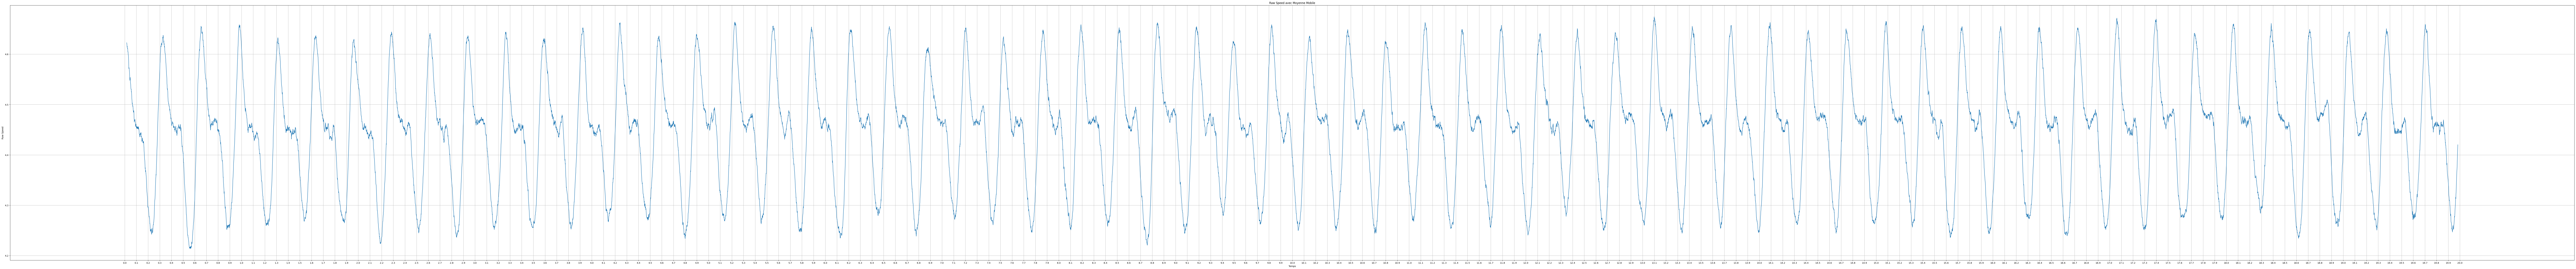

In [44]:
#First graph

#Moyenne mobile contrôlable : averages_vals_df = pd.DataFrame(averages_vals)

moving_average_raw_speed_1 = filtered_speed.rolling(window=35, center=True).mean()
# moving_average_raw_speed_2 = filtered_speed.rolling(window=35, center=True).mean()
# moving_average_raw_speed_3 = filtered_speed.rolling(window=36, center=True).mean()
# moving_average_raw_speed_4 = filtered_speed.rolling(window=37, center=True).mean()


%matplotlib inline

moving_average_raw_speed_1_df = pd.DataFrame({'Time': time, 'Moving Average Raw Speed': moving_average_raw_speed_1})
# moving_average_raw_speed_2_df = pd.DataFrame({'Time': time, 'Moving Average Raw Speed': moving_average_raw_speed_2})
# moving_average_raw_speed_3_df = pd.DataFrame({'Time': time, 'Moving Average Raw Speed': moving_average_raw_speed_3})
# moving_average_raw_speed_4_df = pd.DataFrame({'Time': time, 'Moving Average Raw Speed': moving_average_raw_speed_4})

plt.figure(figsize=(200, 20))

plt.plot(moving_average_raw_speed_1_df['Time'], moving_average_raw_speed_1_df['Moving Average Raw Speed'], label='Moyenne mobile de Raw Speed filtrée')
# plt.plot(moving_average_raw_speed_2_df['Time'], moving_average_raw_speed_2_df['Moving Average Raw Speed'], label='Moyenne mobile de Raw Speed', color='green', alpha=0.8)
# plt.plot(moving_average_raw_speed_3_df['Time'], moving_average_raw_speed_3_df['Moving Average Raw Speed'], label='Moyenne mobile de Raw Speed', color='yellow', alpha=0.8)
# plt.plot(moving_average_raw_speed_4_df['Time'], moving_average_raw_speed_4_df['Moving Average Raw Speed'], label='Moyenne mobile de Raw Speed', color='red', alpha=0.8)

plt.xticks(np.arange(min(time), max(time) + 0.1, 0.1))
plt.grid()
plt.xlabel('Temps')
plt.ylabel('Raw Speed')
plt.title('Raw Speed avec Moyenne Mobile')
plt.show()


In [45]:
# Détecter les vallées et les peaks
averages_vals = []

for i in range(10, len(moving_average_raw_speed_1) - 10):
    if pd.notna(moving_average_raw_speed_1[i]):  # Vérifier que la valeur n'est pas NaN
        window = moving_average_raw_speed_1[i - 10:i + 11]
        min_value = window.min()
        max_value = window.max()

        is_vallee = moving_average_raw_speed_1[i] == min_value and moving_average_raw_speed_1[i] < seuil_v
        is_pic = moving_average_raw_speed_1[i] == max_value and moving_average_raw_speed_1[i] > seuil_p

        averages_vals.append((time[i], moving_average_raw_speed_1[i], ''))


In [46]:
# Pose et levé de pied
lift_down = []
lift_off = []

previous_mode = None
for i in range(len(contact_mode)):
    if pd.notna(contact_mode[i]):
        current_mode = contact_mode[i]
        if (previous_mode is None or previous_mode != 'SC') and current_mode == 'SC':
            lift_down.append((time[i], 'Pose de Pied'))
        previous_mode = current_mode
        
previous_mode = None
for i in range(len(contact_mode)):
    if pd.notna(contact_mode[i]):
        current_mode = contact_mode[i]
        if (previous_mode is None or previous_mode != 'Aerial') and current_mode == 'Aerial':
            lift_off.append((time[i], 'Levé de Pied'))
        previous_mode = current_mode
            

In [47]:
# Créer des DataFrames pour les vallées, les peaks et les transitions
df_valleys = pd.DataFrame(valleys, columns=['Time', 'Speed', 'Type'])
df_peaks = pd.DataFrame(peaks, columns=['Time', 'Speed', 'Type'])
lift_down_df = pd.DataFrame(lift_down, columns=['Time', 'Type'])
lift_off_df = pd.DataFrame(lift_off, columns=['Time', 'Type'])

# Calculer la différence de temps entre chaque valeur x+1 et x.
df_valleys['Time difference'] = df_valleys['Time'].diff().shift(-1).abs()
df_peaks['Time difference'] = df_peaks['Time'].diff().shift(-1).abs()
lift_down_df['Time difference'] = lift_down_df['Time'].diff().shift(-1).abs()
lift_off_df['Time difference'] = lift_off_df['Time'].diff().shift(-1).abs()

# Arrondir les valeurs de vitesse et de différence de temps
df_valleys['Speed'] = df_valleys['Speed'].round(5)
df_peaks['Speed'] = df_peaks['Speed'].round(5)
df_valleys['Time difference'] = df_valleys['Time difference'].round(4)
df_peaks['Time difference'] = df_peaks['Time difference'].round(4)
lift_down_df['Time difference'] = lift_down_df['Time difference'].round(4)
lift_off_df['Time difference'] = lift_off_df['Time difference'].round(4)


In [48]:
def check_values(df):
    if not df.empty:
        errors = []
        df['Errors'] = [None] * len(df['Time difference'])
        # Vérifier les différences de temps pour les valeurs
        for index, row in df.iterrows():
            if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
                df.loc[index, "Errors"] = "ERR"
                errors.append(index)

        if len(errors) > 0:
            msg = ', '.join(map(str, errors))
            print(f"{len(errors)} Erreurs sur les index {msg}\n")

if valleys is not None and peaks is not None and lift_down is not None and lift_off is not None:
    print("Vérification pour valleys\n")
    check_values(df_valleys)
    print("Vérification pour peaks\n")
    check_values(df_peaks)
    print("Vérification pour Pose de pied\n")
    check_values(lift_down_df)
    print("Vérification pour Levé de pied\n")
    check_values(lift_off_df)

Vérification pour valleys

Vérification pour peaks

Vérification pour Pose de pied

Vérification pour Levé de pied



In [49]:
def write_results_to_file(valleys, peaks, lift_down, lift_off, output_file):
    with open(output_file, 'w') as f:
        f.write("Vallées détectées:\t")
        if not valleys.empty:
            f.write(f"({len(valleys)})\n")
            valleys.to_csv(f, index=False, sep='\t', lineterminator="\n")
            # Vérifier les différences de temps pour les vallées
            for index, row in valleys.iterrows():
                if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
                    f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les vallées\n")
        else:
            f.write("Aucune vallée détectée.\n")


        f.write("\nPics détectés:\t")
        if not peaks.empty:
            f.write(f"({len(peaks)})\n")
            peaks.to_csv(f, index=False, sep='\t', lineterminator="\n")
            # Vérifier les différences de temps pour les peaks
            for index, row in peaks.iterrows():
                if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
                    f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les peaks\n")
        else:
            f.write("Aucun pic détecté.\n")


        f.write("\nPied posé dans contact_mode :\t")
        if not lift_down.empty:
            f.write(f"({len(lift_down)})\n")
            lift_down.to_csv(f, index=False, sep='\t', lineterminator="\n")
            # Vérifier les différences de temps pour les transitions
            for index, row in lift_down.iterrows():
                if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
                    f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les Pose de pied\n")
        else:
            f.write("Aucune pose de pied détectée.\n")


        f.write("\nPied levé dans contact_mode :\t")
        if not lift_off.empty:
            f.write(f"({len(lift_off)})\n")
            lift_off.to_csv(f, index=False, sep='\t', lineterminator="\n")
            # Vérifier les différences de temps pour les transitions
            for index, row in lift_off.iterrows():
                if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
                    f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les Pose de pied\n")
        else:
            f.write("Aucune pose de pied détectée.\n")

def write_results_to_excel(valleys, peaks, lift_off, lift_down, output_file):
    # Create a Pandas Excel writer using XlsxWriter as the engine
    with pd.ExcelWriter(output_file) as writer:
        # Write each dataframe to a different worksheet
        valleys.to_excel(writer, sheet_name='Vallées', index=False)
        peaks.to_excel(writer, sheet_name='Pics', index=False)
        lift_off.to_excel(writer, sheet_name='Levé de pied', index=False)
        lift_down.to_excel(writer, sheet_name='Pose de pied', index=False)

    print(f"Le tableau excel à bien été crée dans  {output_file}")

if valleys is not None and peaks is not None and lift_down is not None and lift_off is not None :
    write_results_to_file( df_valleys, df_peaks, lift_down_df, lift_off_df, output_file)
    write_results_to_excel(df_valleys, df_peaks, lift_down_df, lift_off_df, output_file.replace(".txt", ".xlsx"))
    print(f"Le fichier txt a été crée dans : {output_file}")

Dataframes were successfully written to D:\\Documents\\Mémoire\\Data John Doe\\Auto Python\\RAWSpeed\\ResultPython_JD_R16.xlsx
Les résultats ont été écrits dans le fichier : D:\\Documents\\Mémoire\\Data John Doe\\Auto Python\\RAWSpeed\\ResultPython_JD_R16.txt


In [52]:
%matplotlib inline

averages_vals_df = pd.DataFrame(averages_vals)
lift_off_df = pd.DataFrame(lift_off)
lift_down_df = pd.DataFrame(lift_down)

plt.figure(figsize=(100, 6))

plt.scatter(df_valleys['Time'][i], df_valleys['Moving Average Raw Speed'], color='green', label='valleys')
plt.scatter(df_peaks['Time'][i], df_peaks['Moving Average Raw Speed'], color='blue', label='peaks')
plt.plot(averages_vals_df[0], averages_vals_df[1], color="black")

# Tracer les barres verticales pour lift_off et lift_down
for i in range(len(lift_off_df)):
    plt.axvline(x=lift_off_df['Time'][i], color='orange', label='Levé de pas' if i == 0 else "")
for i in range(len(lift_down_df)):
    plt.axvline(x=lift_down_df['Time'][i], color='yellow', label='Pose de pas' if i == 0 else "")

plt.xticks(np.arange(0, max(averages_vals_df[0]) + 1, 0.1))
plt.xlabel('0')
plt.ylabel('1')
plt.title('Plot of DataFrame')
plt.grid(True)
plt.show()

KeyError: 'Time'

<Figure size 10000x600 with 0 Axes>